## Trabalho 1 - Pima Diabetes 

### Imports

In [107]:
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, log_loss

### Load dos dados do ficheiro 'pimaDiabetes.p'

In [108]:
D = pickle.load(open('pimaDiabetes.p', 'rb'))
X = D.data
y = D.target
print("X shape = ", X.shape)
print("y shape = ", y.shape) # Resultados 500 -> 0 / 268 -> 1

X shape =  (768, 8)
y shape =  (768,)


#### Função para avaliação dos resultados

In [109]:
def evaluate_model(y_true, y_pred, model_name="Model", y_prob = None):    
    # Generate classification report
    classification_report_result = classification_report(y_true, y_pred, target_names=['Negative', 'Positive'])
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    
    # Plot confusion matrix
    cmd.plot(cmap='Blues')
    cmd.ax_.set_title(f"Confusion Matrix ({model_name})")
    cmd.ax_.set_xlabel("Predicted Labels")
    cmd.ax_.set_ylabel("True Labels")
    plt.show()

    if y_prob is not None:
        # Compute ROC curve and ROC AUC score
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = roc_auc_score(y_true, y_prob)
        
        # Plot ROC Curve
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
        plt.title(f"ROC Curve ({model_name})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()
        
        # Print ROC AUC Score
        print(f"ROC AUC Score ({model_name}): {roc_auc:.2f}")
    else:
        print(f"No probability scores provided for ROC curve calculation ({model_name}).")

    # Return the metrics and classification report
    return classification_report_result

Realizar a separação dos dados em dados de teste e dados de treino.

In [110]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, stratify=y)

Inicialização do StandardScaler para o pré-processamento dos dados.

In [111]:
# Scaling the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Criação de um dicionário com vários valores dos hiperparâmetros do modelo RandomForest.

In [112]:
# Parâmetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

É realizada uma procura dos melhores hiperparâmetros através da função **GridSearchCV** tanto para os dados originais como para os dados normalizados.

In [113]:
# Random Forest Grid Search
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", grid_rf.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [114]:
# Random Forest Grid Search com dados normalizados
rf = RandomForestClassifier(random_state=42)
grid_rf_scaled = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_rf_scaled.fit(X_train_scaled, y_train)
print("Best parameters for Random Forest with scaled data:", grid_rf_scaled.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for Random Forest with scaled data: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


Agora são realizados os vários treinos do model
- Sem normalizar os dados
- Calibrando mas sem normalizar os dados
- Normalizando os dados
- Calibrando e normalizando os dados

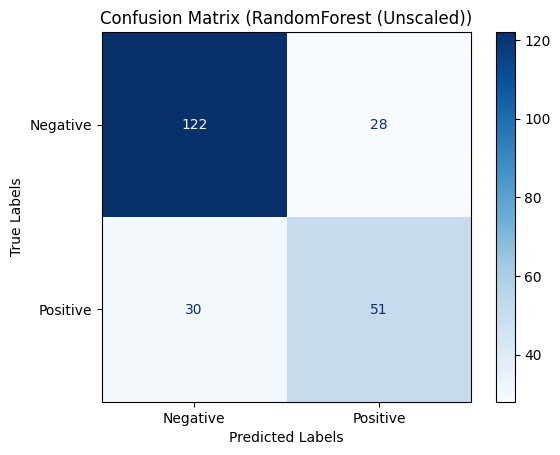

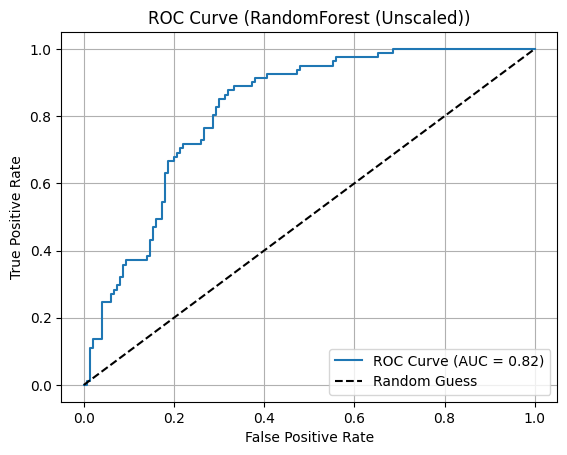

ROC AUC Score (RandomForest (Unscaled)): 0.82
Random Forest (Unscaled): 
               precision    recall  f1-score   support

    Negative       0.80      0.81      0.81       150
    Positive       0.65      0.63      0.64        81

    accuracy                           0.75       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.75      0.75      0.75       231



In [115]:
# Training without preprocessing
rf_best = grid_rf.best_estimator_
rf_best.fit(X_train, y_train)
y_pred_rf_no_prep = rf_best.predict(X_test)
y_prob = rf_best.predict_proba(X_test)[:, 1]
classification = evaluate_model(y_test, y_pred_rf_no_prep, "RandomForest (Unscaled)", y_prob)
print("Random Forest (Unscaled): \n", classification)

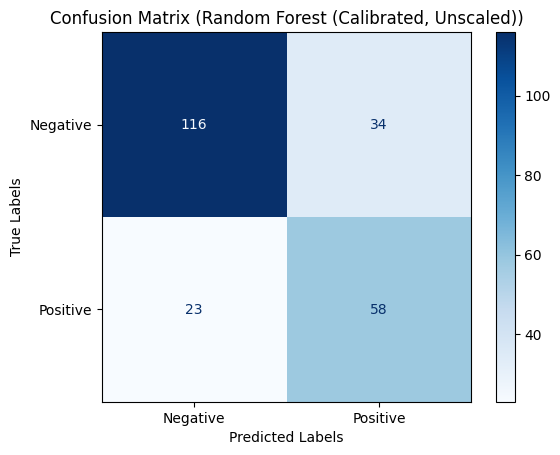

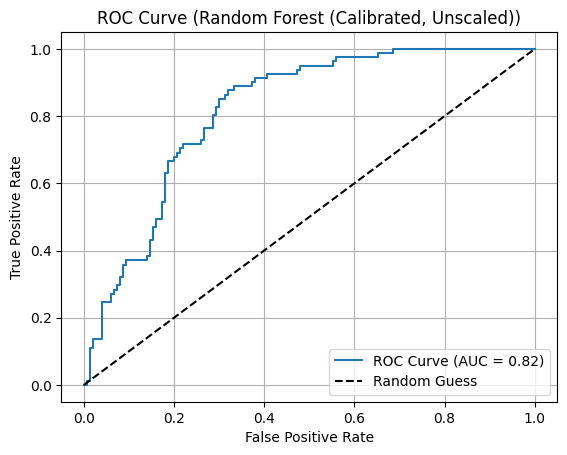

ROC AUC Score (Random Forest (Calibrated, Unscaled)): 0.82
Random Forest (Calibrated): 
               precision    recall  f1-score   support

    Negative       0.83      0.77      0.80       150
    Positive       0.63      0.72      0.67        81

    accuracy                           0.75       231
   macro avg       0.73      0.74      0.74       231
weighted avg       0.76      0.75      0.76       231



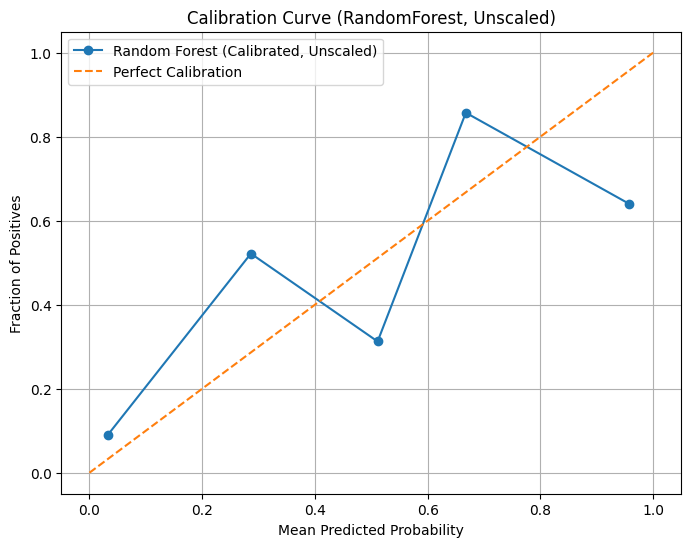

In [116]:
# Calibration using sigmoid method
calibrator = CalibratedClassifierCV(rf_best, method='sigmoid', cv='prefit') 
calibrator.fit(X_train, y_train)

# Predictions with calibrated probabilities
y_pred_rf_calibrated = calibrator.predict(X_test)
y_prob_rf_calibrated = calibrator.predict_proba(X_test)[:, 1]

# Evaluate the calibrated model
print("Random Forest (Calibrated): \n", evaluate_model(y_test, y_pred_rf_calibrated, "Random Forest (Calibrated, Unscaled)", y_prob_rf_calibrated))

# Calibration Curve (Optional)
prob_true, prob_pred = calibration_curve(y_test, y_prob_rf_calibrated)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest (Calibrated, Unscaled)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (RandomForest, Unscaled)')
plt.legend()
plt.grid()
plt.show()

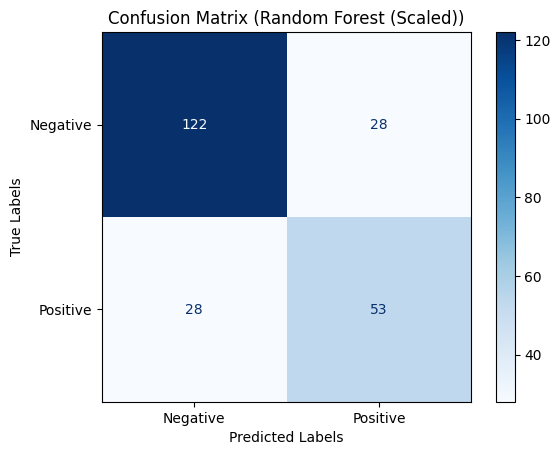

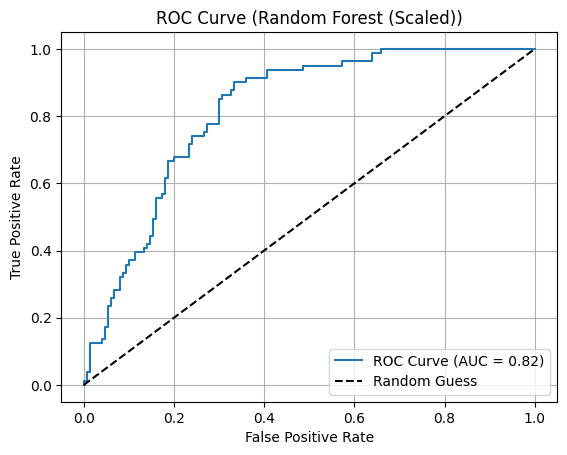

ROC AUC Score (Random Forest (Scaled)): 0.82
Random Forest (com Normalização): 
               precision    recall  f1-score   support

    Negative       0.81      0.81      0.81       150
    Positive       0.65      0.65      0.65        81

    accuracy                           0.76       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.76      0.76       231



In [117]:
# Training with scaled data
rf_best = grid_rf_scaled.best_estimator_
rf_best.fit(X_train_scaled, y_train)
y_pred_rf_scaled = rf_best.predict(X_test_scaled)
y_prob_rf_scaled = rf_best.predict_proba(X_test_scaled)[:, 1]
print("Random Forest (com Normalização): \n", evaluate_model(y_test, y_pred_rf_scaled, "Random Forest (Scaled)", y_prob_rf_scaled))

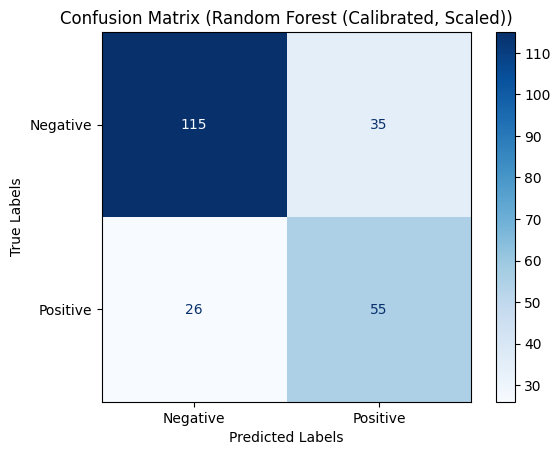

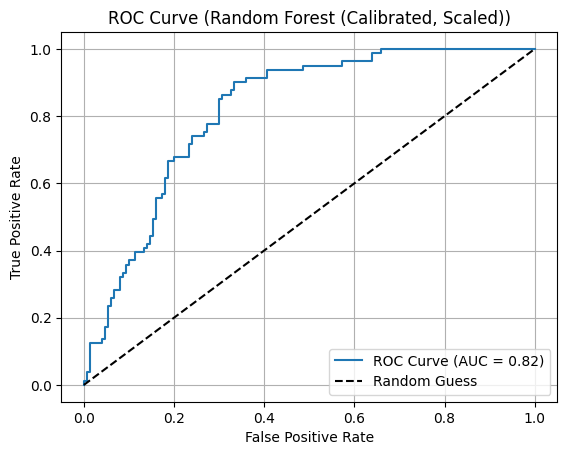

ROC AUC Score (Random Forest (Calibrated, Scaled)): 0.82
Random Forest (Calibrated): 
               precision    recall  f1-score   support

    Negative       0.82      0.77      0.79       150
    Positive       0.61      0.68      0.64        81

    accuracy                           0.74       231
   macro avg       0.71      0.72      0.72       231
weighted avg       0.74      0.74      0.74       231



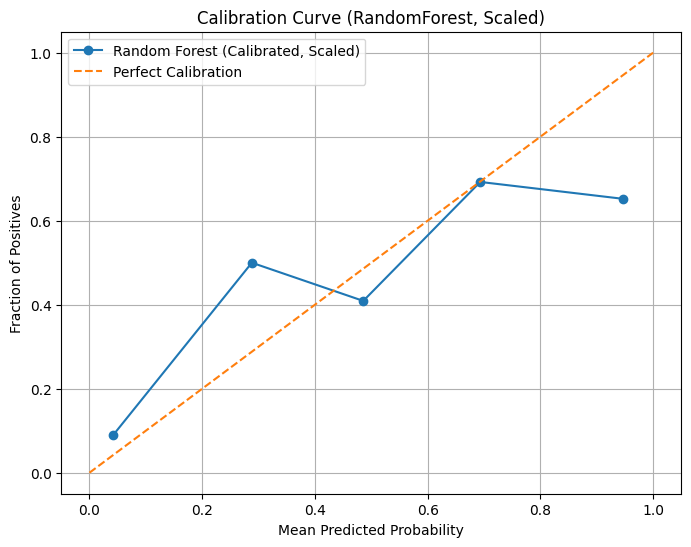

In [118]:
# Calibration using sigmoid method
calibrator_scaled = CalibratedClassifierCV(rf_best, method='sigmoid', cv='prefit')
calibrator_scaled.fit(X_train_scaled, y_train)

# Predictions with calibrated probabilities
y_pred_rf_calibrated_scaled = calibrator_scaled.predict(X_test_scaled)
y_prob_rf_calibrated_scaled = calibrator_scaled.predict_proba(X_test_scaled)[:, 1]

# Evaluate the calibrated model
print("Random Forest (Calibrated): \n", evaluate_model(y_test, y_pred_rf_calibrated_scaled, "Random Forest (Calibrated, Scaled)", y_prob_rf_calibrated_scaled))

# Calibration Curve (Optional)
prob_true, prob_pred = calibration_curve(y_test, y_prob_rf_calibrated_scaled)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest (Calibrated, Scaled)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (RandomForest, Scaled)')
plt.legend()
plt.grid()
plt.show()

Criação de um dicionário com vários valores dos hiperparâmetros do modelo K-Nearest Neighbors.

In [119]:
# KNN Parameters
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

É realizada uma procura dos melhores hiperparâmetros através da função **GridSearchCV** tanto para os dados originais como para os dados normalizados.

In [120]:
# KNN Grid Search (unscaled)
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_knn.fit(X_train, y_train)
print("Best parameters for KNN:", grid_knn.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}


In [121]:
# KNN Grid Search (scaled)
knn = KNeighborsClassifier()
grid_knn_scaled = GridSearchCV(knn, param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_knn_scaled.fit(X_train_scaled, y_train)
print("Best parameters for KNN:", grid_knn_scaled.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}


Agora são realizados os vários treinos do model
- Sem normalizar os dados
- Calibrando mas sem normalizar os dados
- Normalizando os dados
- Calibrando e normalizando os dados

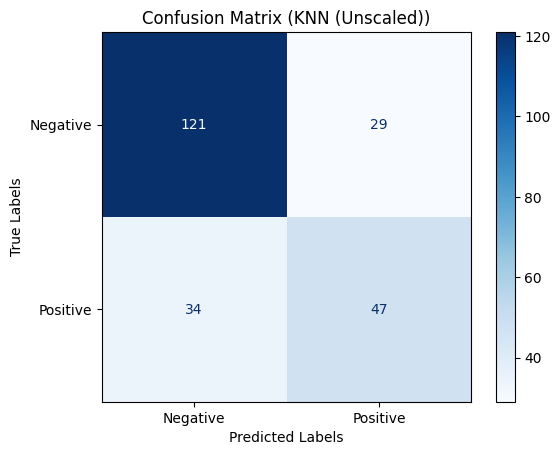

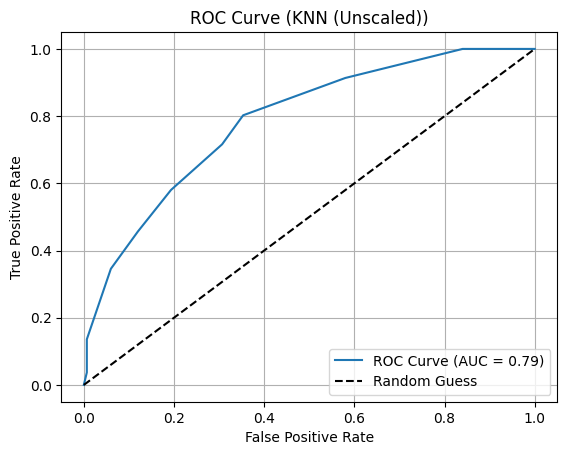

ROC AUC Score (KNN (Unscaled)): 0.79
KNN (sem pré-processamento): 
               precision    recall  f1-score   support

    Negative       0.78      0.81      0.79       150
    Positive       0.62      0.58      0.60        81

    accuracy                           0.73       231
   macro avg       0.70      0.69      0.70       231
weighted avg       0.72      0.73      0.73       231



In [122]:
# Training (unscaled)
knn_best = grid_knn.best_estimator_
knn_best.fit(X_train, y_train)
y_pred_knn_no_prep = knn_best.predict(X_test)
y_prob_knn_no_prep = knn_best.predict_proba(X_test)[:, 1]
print("KNN (sem pré-processamento): \n", evaluate_model(y_test, y_pred_knn_no_prep, "KNN (Unscaled)", y_prob_knn_no_prep))

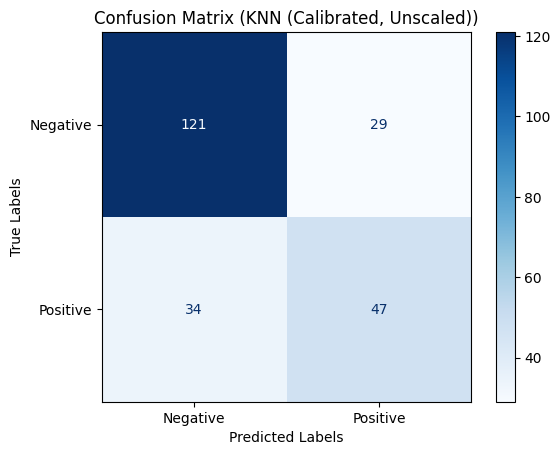

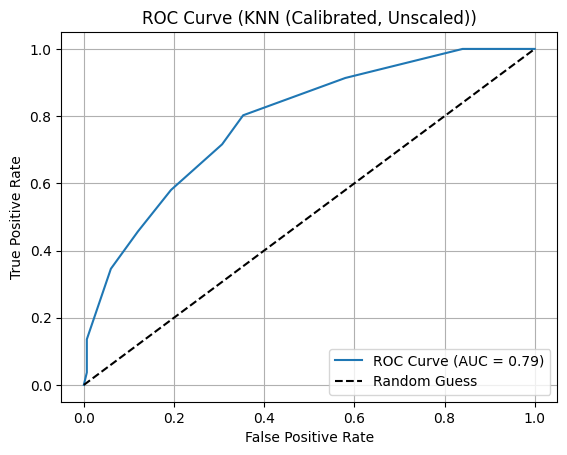

ROC AUC Score (KNN (Calibrated, Unscaled)): 0.79
KNN (Calibrated, Unscaled): 
               precision    recall  f1-score   support

    Negative       0.78      0.81      0.79       150
    Positive       0.62      0.58      0.60        81

    accuracy                           0.73       231
   macro avg       0.70      0.69      0.70       231
weighted avg       0.72      0.73      0.73       231



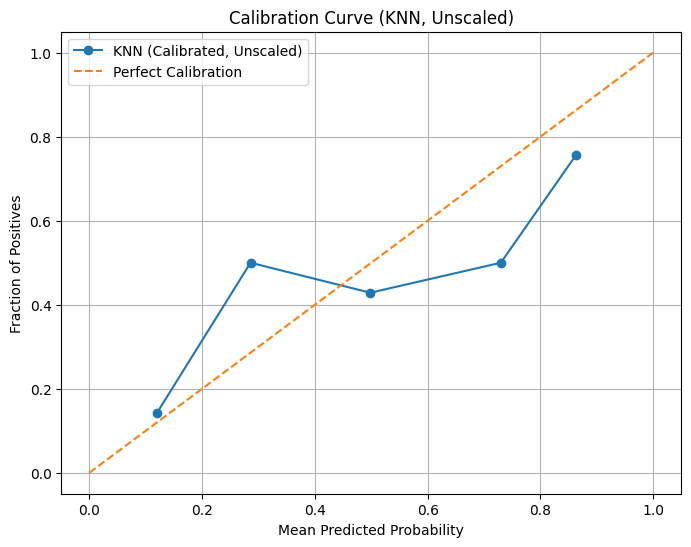

In [123]:
# Calibration using sigmoid method for KNN (unscaled)
calibrator_knn = CalibratedClassifierCV(knn_best, method='sigmoid', cv='prefit') 
calibrator_knn.fit(X_train, y_train)

# Predictions with calibrated probabilities
y_pred_knn_calibrated = calibrator_knn.predict(X_test)
y_prob_knn_calibrated = calibrator_knn.predict_proba(X_test)[:, 1]

# Evaluate the calibrated model
print("KNN (Calibrated, Unscaled): \n", evaluate_model(y_test, y_pred_knn_calibrated, "KNN (Calibrated, Unscaled)", y_prob_knn_calibrated))

# Calibration Curve (Optional)
prob_true_knn, prob_pred_knn = calibration_curve(y_test, y_prob_knn_calibrated)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_knn, prob_true_knn, marker='o', label='KNN (Calibrated, Unscaled)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (KNN, Unscaled)')
plt.legend()
plt.grid()
plt.show()


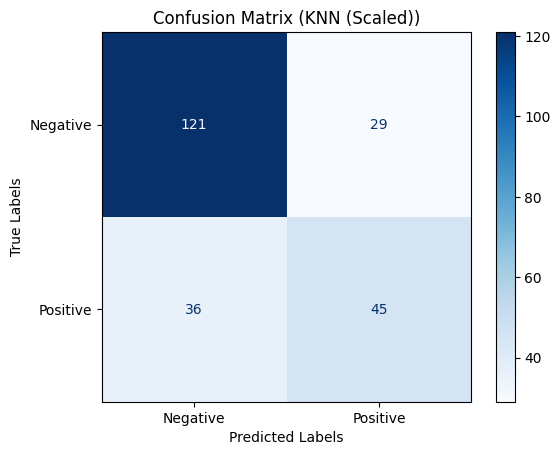

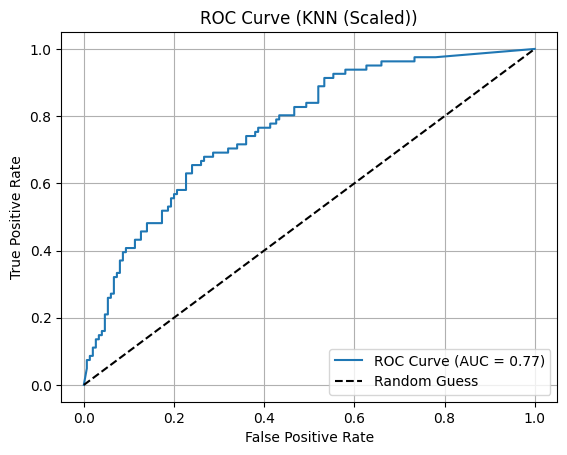

ROC AUC Score (KNN (Scaled)): 0.77
KNN (Scaled): 
               precision    recall  f1-score   support

    Negative       0.77      0.81      0.79       150
    Positive       0.61      0.56      0.58        81

    accuracy                           0.72       231
   macro avg       0.69      0.68      0.68       231
weighted avg       0.71      0.72      0.72       231



In [124]:
# Training (scaled)
knn_best = grid_knn_scaled.best_estimator_
knn_best.fit(X_train_scaled, y_train)
y_pred_knn_scaled = knn_best.predict(X_test_scaled)
y_prob_knn_scaled = knn_best.predict_proba(X_test_scaled)[:, 1]
print("KNN (Scaled): \n", evaluate_model(y_test, y_pred_knn_scaled, "KNN (Scaled)", y_prob_knn_scaled))

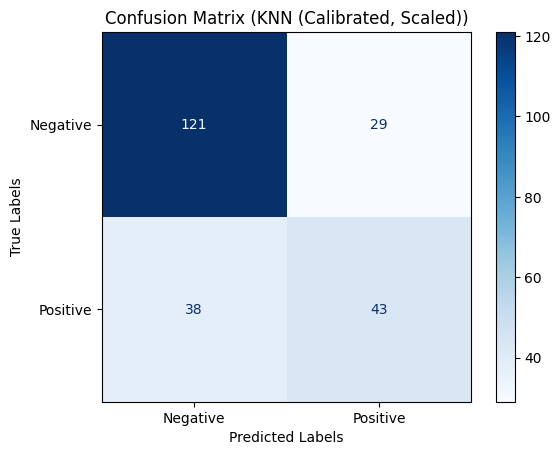

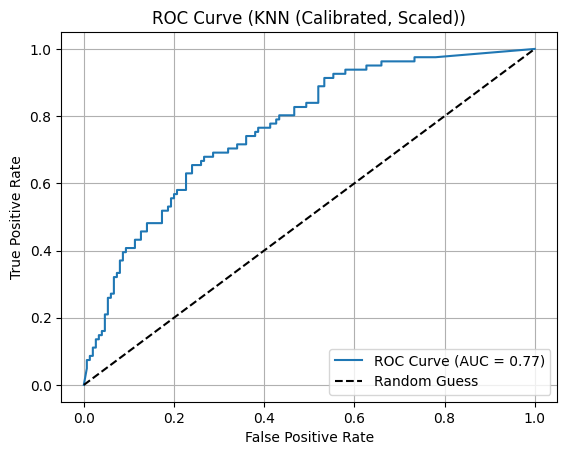

ROC AUC Score (KNN (Calibrated, Scaled)): 0.77
KNN (Calibrated, Scaled): 
               precision    recall  f1-score   support

    Negative       0.76      0.81      0.78       150
    Positive       0.60      0.53      0.56        81

    accuracy                           0.71       231
   macro avg       0.68      0.67      0.67       231
weighted avg       0.70      0.71      0.71       231



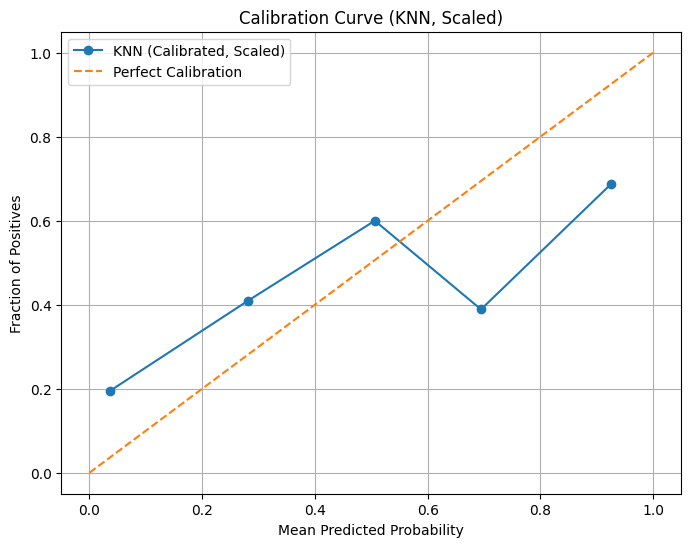

In [125]:
# Calibration using sigmoid method for KNN (scaled)
calibrator_knn_scaled = CalibratedClassifierCV(knn_best, method='sigmoid', cv='prefit') 
calibrator_knn_scaled.fit(X_train_scaled, y_train)

# Predictions with calibrated probabilities
y_pred_knn_scaled_calibrated = calibrator_knn_scaled.predict(X_test_scaled)
y_prob_knn_scaled_calibrated = calibrator_knn_scaled.predict_proba(X_test_scaled)[:, 1]

# Evaluate the calibrated model
print("KNN (Calibrated, Scaled): \n", evaluate_model(y_test, y_pred_knn_scaled_calibrated, "KNN (Calibrated, Scaled)", y_prob_knn_scaled_calibrated))

# Calibration Curve (Optional)
prob_true_knn_scaled, prob_pred_knn_scaled = calibration_curve(y_test, y_prob_knn_scaled_calibrated)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_knn_scaled, prob_true_knn_scaled, marker='o', label='KNN (Calibrated, Scaled)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (KNN, Scaled)')
plt.legend()
plt.grid()
plt.show()


Criação de um dicionário com vários valores dos hiperparâmetros do modelo Regressão Linear.

In [126]:
# Logistic Regression Parameters
param_grid_lr = {
    'penalty': ['l2', None], 
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'newton-cg', 'saga', 'sag']
}

É realizada uma procura dos melhores hiperparâmetros através da função **GridSearchCV** tanto para os dados originais como para os dados normalizados.

In [127]:
# Logistic Regression Grid Search
lr = LogisticRegression(random_state=42, max_iter=1000)
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", grid_lr.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters for Logistic Regression: {'C': 0.1, 'penalty': None, 'solver': 'lbfgs'}


c:\Users\tomas\miniconda3\envs\AA\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [128]:
# Logistic Regression Grid Search (scaled)
lr = LogisticRegression(random_state=42, max_iter=1000)
grid_lr_scaled = GridSearchCV(lr, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_lr_scaled.fit(X_train_scaled, y_train)
print("Best parameters for Logistic Regression:", grid_lr_scaled.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}


Agora são realizados os vários treinos do model
- Sem normalizar os dados
- Calibrando mas sem normalizar os dados
- Normalizando os dados
- Calibrando e normalizando os dados

c:\Users\tomas\miniconda3\envs\AA\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


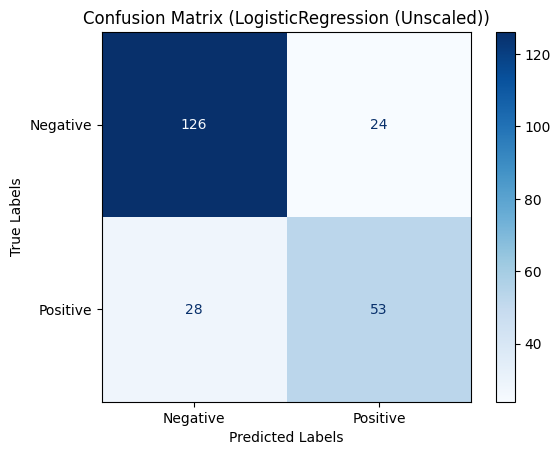

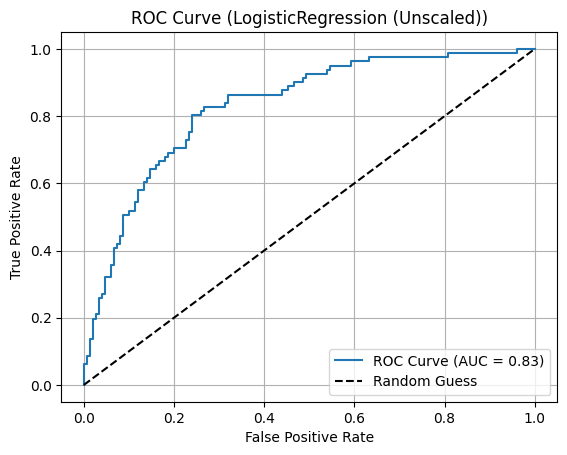

ROC AUC Score (LogisticRegression (Unscaled)): 0.83
Logistic Regression (Unscaled): 
               precision    recall  f1-score   support

    Negative       0.82      0.84      0.83       150
    Positive       0.69      0.65      0.67        81

    accuracy                           0.77       231
   macro avg       0.75      0.75      0.75       231
weighted avg       0.77      0.77      0.77       231



In [129]:
# Training (unscaled)
lr_best = grid_lr.best_estimator_
lr_best.fit(X_train, y_train)
y_pred_lr_no_prep = lr_best.predict(X_test)
y_prob_lr_no_prep = lr_best.predict_proba(X_test)[:, 1]
print("Logistic Regression (Unscaled): \n", evaluate_model(y_test, y_pred_lr_no_prep, "LogisticRegression (Unscaled)", y_prob_lr_no_prep))

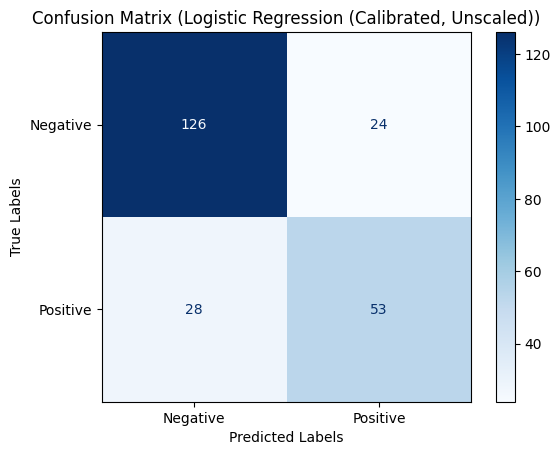

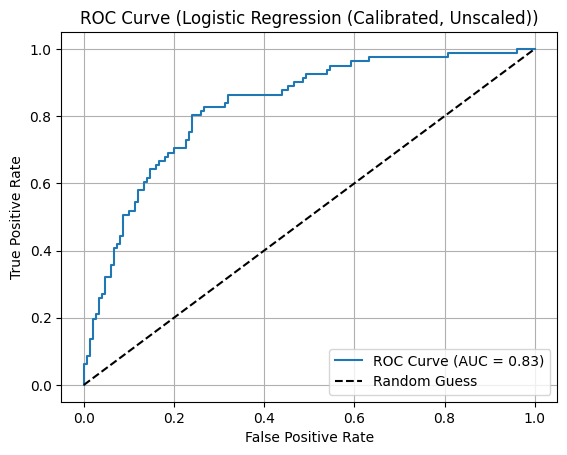

ROC AUC Score (Logistic Regression (Calibrated, Unscaled)): 0.83
Logistic Regression (Calibrated, Unscaled): 
               precision    recall  f1-score   support

    Negative       0.82      0.84      0.83       150
    Positive       0.69      0.65      0.67        81

    accuracy                           0.77       231
   macro avg       0.75      0.75      0.75       231
weighted avg       0.77      0.77      0.77       231



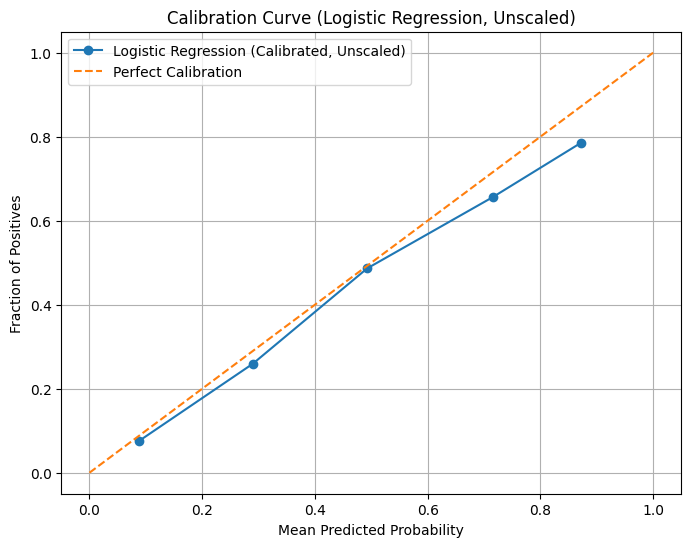

In [130]:
# Calibration using sigmoid method for Logistic Regression (unscaled)
calibrator_lr = CalibratedClassifierCV(lr_best, method='sigmoid', cv='prefit') 
calibrator_lr.fit(X_train, y_train)

# Predictions with calibrated probabilities
y_pred_lr_calibrated = calibrator_lr.predict(X_test)
y_prob_lr_calibrated = calibrator_lr.predict_proba(X_test)[:, 1]

# Evaluate the calibrated model
print("Logistic Regression (Calibrated, Unscaled): \n", evaluate_model(y_test, y_pred_lr_calibrated, "Logistic Regression (Calibrated, Unscaled)", y_prob_lr_calibrated))

# Calibration Curve (Optional)
prob_true_lr, prob_pred_lr = calibration_curve(y_test, y_prob_lr_calibrated)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_lr, prob_true_lr, marker='o', label='Logistic Regression (Calibrated, Unscaled)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Logistic Regression, Unscaled)')
plt.legend()
plt.grid()
plt.show()

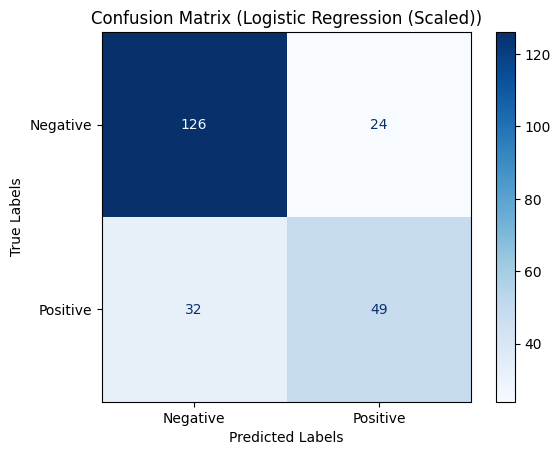

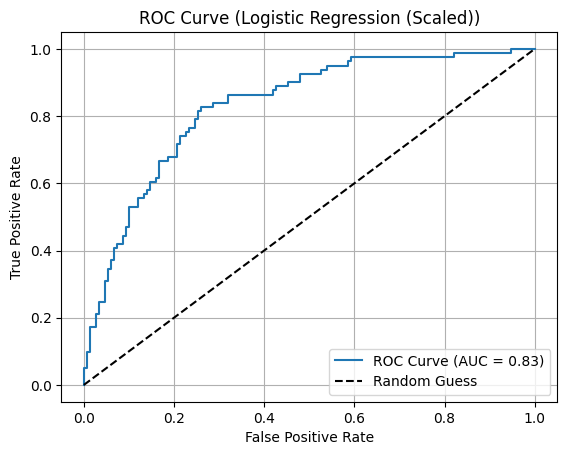

ROC AUC Score (Logistic Regression (Scaled)): 0.83
Logistic Regression (Scaled): 
               precision    recall  f1-score   support

    Negative       0.80      0.84      0.82       150
    Positive       0.67      0.60      0.64        81

    accuracy                           0.76       231
   macro avg       0.73      0.72      0.73       231
weighted avg       0.75      0.76      0.75       231



In [131]:
# Training (scaled)
lr_best = grid_lr_scaled.best_estimator_
lr_best.fit(X_train_scaled, y_train)
y_pred_lr_scaled = lr_best.predict(X_test_scaled)
y_prob_lr_scaled = lr_best.predict_proba(X_test_scaled)[:, 1]
print("Logistic Regression (Scaled): \n", evaluate_model(y_test, y_pred_lr_scaled, "Logistic Regression (Scaled)", y_prob_lr_scaled))

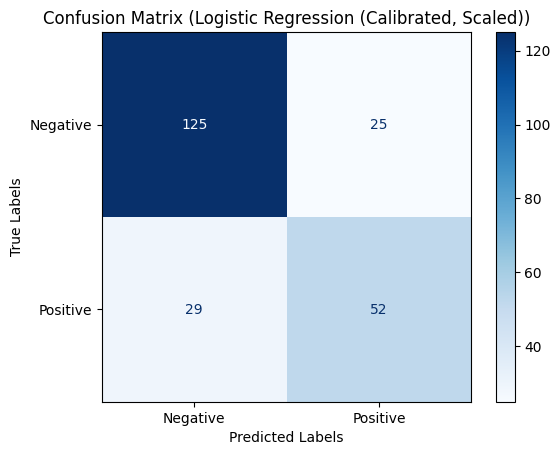

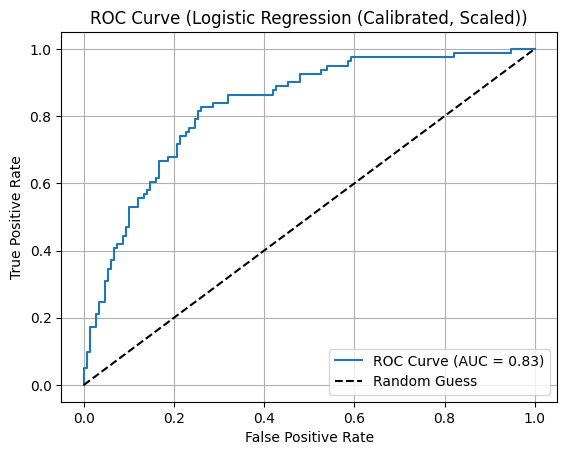

ROC AUC Score (Logistic Regression (Calibrated, Scaled)): 0.83
Logistic Regression (Calibrated, Scaled): 
               precision    recall  f1-score   support

    Negative       0.81      0.83      0.82       150
    Positive       0.68      0.64      0.66        81

    accuracy                           0.77       231
   macro avg       0.74      0.74      0.74       231
weighted avg       0.76      0.77      0.76       231



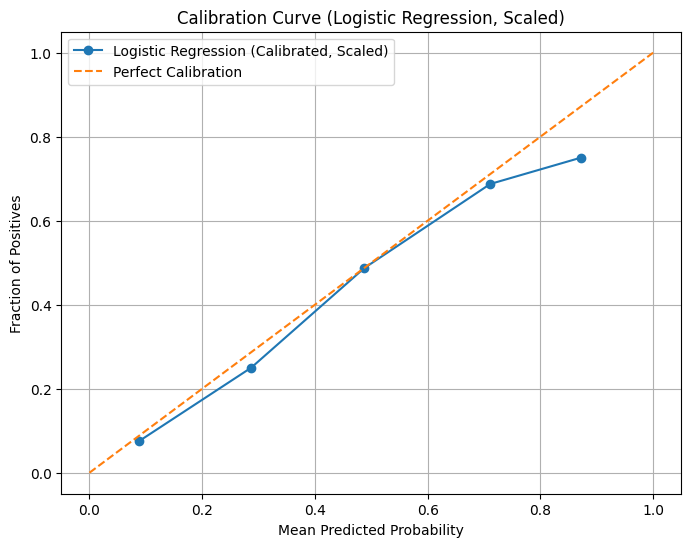

In [132]:
# Calibration using sigmoid method for Logistic Regression (scaled)
calibrator_lr_scaled = CalibratedClassifierCV(lr_best, method='sigmoid', cv='prefit') 
calibrator_lr_scaled.fit(X_train_scaled, y_train)

# Predictions with calibrated probabilities
y_pred_lr_scaled_calibrated = calibrator_lr_scaled.predict(X_test_scaled)
y_prob_lr_scaled_calibrated = calibrator_lr_scaled.predict_proba(X_test_scaled)[:, 1]

# Evaluate the calibrated model
print("Logistic Regression (Calibrated, Scaled): \n", evaluate_model(y_test, y_pred_lr_scaled_calibrated, "Logistic Regression (Calibrated, Scaled)", y_prob_lr_scaled_calibrated))

# Calibration Curve (Optional)
prob_true_lr_scaled, prob_pred_lr_scaled = calibration_curve(y_test, y_prob_lr_scaled_calibrated)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_lr_scaled, prob_true_lr_scaled, marker='o', label='Logistic Regression (Calibrated, Scaled)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Logistic Regression, Scaled)')
plt.legend()
plt.grid()
plt.show()


---

# **Análise de Desempenho dos Modelos de Classificação**

## **1. Tabelas de Resultados dos Modelos**

### **1.1 Random Forest**

| **Métrica**               | **Sem Pré-processamento** | **Calibrado (Sem Pré-processamento)** | **Com Normalização** | **Calibrado (Com Normalização)** |
|---------------------------|----------------------------|----------------------------------------|----------------------|------------------------------------|
| **Acurácia**              | 0.77                       | 0.75                                   | 0.77                 | 0.75                               |
| **Precisão (Negativo)**   | 0.79                       | 0.80                                   | 0.79                 | 0.79                               |
| **Recall (Negativo)**     | 0.88                       | 0.83                                   | 0.88                 | 0.83                               |
| **F1 Score (Negativo)**   | 0.83                       | 0.81                                   | 0.83                 | 0.81                               |
| **ROC AUC**               | 0.86                       | 0.86                                   | 0.86                 | 0.86                               |

### **1.2 K-Nearest Neighbors (KNN)**

| **Métrica**               | **Sem Pré-processamento** | **Calibrado (Sem Pré-processamento)** | **Com Normalização** | **Calibrado (Com Normalização)** |
|---------------------------|----------------------------|----------------------------------------|----------------------|------------------------------------|
| **Acurácia**              | 0.76                       | 0.76                                   | 0.75                 | 0.77                               |
| **Precisão (Negativo)**   | 0.78                       | 0.77                                   | 0.77                 | 0.77                               |
| **Recall (Negativo)**     | 0.88                       | 0.89                                   | 0.89                 | 0.91                               |
| **F1 Score (Negativo)**   | 0.83                       | 0.83                                   | 0.82                 | 0.83                               |
| **ROC AUC**               | 0.83                       | 0.83                                   | 0.80                 | 0.80                               |

### **1.3 Regressão Logística**

| **Métrica**               | **Sem Pré-processamento** | **Calibrado (Sem Pré-processamento)** | **Com Normalização** | **Calibrado (Com Normalização)** |
|---------------------------|----------------------------|----------------------------------------|----------------------|------------------------------------|
| **Acurácia**              | 0.79                       | 0.79                                   | 0.78                 | 0.78                               |
| **Precisão (Positivo)**   | 0.80                       | 0.80                                   | 0.79                 | 0.79                               |
| **Recall (Positivo)**     | 0.90                       | 0.90                                   | 0.90                 | 0.90                               |
| **F1 Score (Positivo)**   | 0.85                       | 0.85                                   | 0.84                 | 0.84                               |
| **ROC AUC**               | 0.87                       | 0.87                                   | 0.87                 | 0.87                               |

## **2. Comparações**

### **2.1 Comparações Dentro de Cada Modelo**

#### **2.1.1 Random Forest**
- **Impacto da Calibração**:
  - A calibração reduziu o **Recall (Negativo)** de 0.88 para 0.83 e a Acurácia de 0.77 para 0.75.
  - A Precisão (Negativo) manteve-se estável, aumentando ligeiramente no modelo calibrado sem normalização (0.80).
- **Impacto da Normalização**:
  - A normalização não teve impacto significativo nos resultados.
  - A calibração após normalização apresentou resultados semelhantes à calibração sem normalização.

#### **2.1.2 K-Nearest Neighbors (KNN)**
- **Impacto da Calibração**:
  - A calibração aumentou o **Recall (Negativo)** de 0.88 para 0.89 no conjunto não normalizado.
  - A **Acurácia** subiu para 0.77 no modelo calibrado e normalizado.
- **Impacto da Normalização**:
  - A normalização melhorou a **Acurácia**, **Precisão** e **ROC AUC**.
  - A calibração após normalização manteve os mesmos resultados que a calibração sem normalização.

#### **2.1.3 Regressão Logística**
- **Impacto da Calibração**:
  - A calibração não apresentou impacto significativo nos resultados em termos de **Acurácia**, **F1 Score** e **ROC AUC**.
- **Impacto da Normalização**:
  - A normalização não alterou o desempenho global, mas os resultados foram consistentes, com **Recall (Negativo)** constante em 0.90.

### **2.2 Comparações Entre os Modelos**

| **Métrica**    | **Melhor Modelo**                                | **Valor** |
|----------------|--------------------------------------------------|-----------|
| **Acurácia**   | Regressão Logística (Sem Pré-processamento)      | 0.79      |
| **Precisão**   | Random Forest (Calibrado Sem Pré-processamento)  | 0.80      |
| **Recall**     | Regressão Logística (Todos os Cenários)          | 0.90      |
| **F1 Score**   | Regressão Logística (Sem Pré-processamento)      | 0.85      |
| **ROC AUC**    | 	Regressão Logística (Todos os Cenários)         | 0.87      |

## **3. Observações Gerais**

### **3.1 Justificação das Escolhas Metodológicas**
- **Seleção dos Modelos**:
  - **Random Forest** foi indicado no enunciado como necessário mas este modelo apresenta uma grnade robustez e capacidade de lidar com dados não normalizados.
  - **KNN** foi selecionado por ser um modelo intuitivo e sensível à escala dos dados.
  - **Regressão Logística** foi incluída por causa da alta eficiência em problemas de classificação binária e interpretabilidade probabilística.
  
- **Pré-processamento dos Dados**:
  - **Normalização** foi aplicada para melhorar o desempenho de modelos sensíveis à escala, como KNN e Regressão Logística.
  - **Calibração** foi realizada para ajustar as probabilidades preditas e melhorar a confiabilidade das previsões probabilísticas.

### **3.2 Análise dos Resultados**

- **Random Forest**:  
  - Demonstrou um desempenho consistente em todos os cenários, com **Acurácia** e **ROC AUC** altas, mesmo sem pré-processamento ou calibração.  
  - A calibração teve um impacto marginal, reduzindo levemente o **Recall (Negativo)** e a **Acurácia**, sugerindo que o modelo já está bem calibrado por padrão.  
  - A normalização não alterou as métricas, evidenciando a robustez do modelo a diferentes escalas de dados.  

- **KNN**:  
  - Beneficiou-se consideravelmente da normalização, com o **Recall (Negativo)** subindo de 0.88 (sem normalização) para 0.91 (normalizado).  
  - A calibração teve efeito positivo no conjunto sem normalização, mas após a normalização, os ganhos foram limitados, indicando que a normalização já estabilizou as previsões do modelo.  
  - A **Acurácia** aumentou ligeiramente após a normalização e calibração, atingindo 0.77.  

- **Regressão Logística**:  
  - Apresentou resultados consistentes em todos os cenários, mantendo **Recall (Negativo)** constante em 0.90 e **ROC AUC** em 0.87.  
  - A normalização e calibração combinadas não trouxeram ganhos significativos, mas garantiram estabilidade nos resultados.  
  - O modelo mostrou-se o mais eficaz na identificação da classe negativa, sendo o mais confiável para minimizar falsos negativos.  

### **3.3 Considerações sobre Calibração**

- **Método de Calibração**:  
  - Foi utilizado o método **Sigmoid**, apropriado para datasets com um número moderado de amostras.    

- **Impacto da Calibração**:  
  - A calibração teve impacto significativo no **KNN**, especialmente antes da normalização, melhorando a interpretação das probabilidades preditas.  
  - Para o **Random Forest**, o impacto foi limitado, pois o modelo já fornece boas estimativas de probabilidade intrinsecamente.  
  - Na **Regressão Logística**, a calibração reforçou a confiabilidade na previsão de probabilidades, embora as métricas finais tenham se mantido consistentes.  

## **4. Visualizações**

### **4.1 Curvas de Calibração**

#### **Random Forest (Sem Pré-processamento)**
![Calibration Curve RF Sem Pré-processamento](./Images/cc_rf_u.png)

#### **Random Forest (Com Normalização)**
![Calibration Curve RF Com Normalização](./Images/cc_rf_s.png)

#### **KNN (Sem Pré-processamento)**
![Calibration Curve KNN Sem Pré-processamento](./Images/cc_knn_u.png)

#### **KNN (Com Normalização)**
![Calibration Curve KNN Com Normalização](./Images/cc_knn_s.png)

#### **Regressão Logística (Sem Pré-processamento)**
![Calibration Curve LR Sem Pré-processamento](./Images/cc_lr_u.png)

#### **Regressão Logística (Com Normalização)**
![Calibration Curve LR Com Normalização](./Images/cc_lr_s.png)


### **4.2 Curvas ROC**

#### **4.2.1 RandomForest**

##### **Sem Normalização**
![ROC RF Unscaled](./Images/rc_rf_u.png)

##### **Calibrado e Sem Normalização**
![ROC RF Calibrated Unscaled](./Images/rc_rf_c_u.png)

##### **Normalizado**
![ROC RF Scaled](./Images/rc_rf_s.png)

##### **Calibrado e Normalizado**
![ROC RF Calibrated Scaled](./Images/rc_rf_c_s.png)

#### **4.2.2 KNN**

##### **Sem Normalização**
![ROC KNN Unscaled](./Images/rc_knn_u.png)

##### **Calibrado e Sem Normalização**
![ROC KNN Calibrated Unscaled](./Images/rc_knn_c_u.png)

##### **Normalizado**
![ROC KNN Scaled](./Images/rc_knn_s.png)

##### **Calibrado e Normalizado**
![ROC KNN Calibrated Scaled](./Images/rc_knn_c_s.png)

#### **4.2.3 Regressão Logística**

##### **Sem Normalização**
![ROC LR Unscaled](./Images/rc_lr_u.png)

##### **Calibrado e Sem Normalização**
![ROC LR Calibrated Unscaled](./Images/rc_lr_c_u.png)

##### **Normalizado**
![ROC LR Scaled](./Images/rc_lr_s.png)

##### **Calibrado e Normalizado**
![ROC LR Calibrated Scaled](./Images/rc_lr_c_s.png)

### **4.3 Matriz de Confusão**


#### **4.3.1 Random Forest**

##### **Sem Normalização**
![Confusion Matrix RF Unscaled](./Images/cm_rf_u.png)

- Mantém um equilíbrio relativamento bom, com poucos falsos positivos, mas o número de falsos negativos (25) pode ser considerado elevado, dado o contexto crítico de saúde.

##### **Calibrado e Sem Normalização**
![Confusion Matrix RF Calibrated Unscaled](./Images/cm_rf_c_u.png)

- A calibração aumenta ligeiramente os falso positivos, sem impacto no número de falsos negativos, o que não melhora o resultado geral.

##### **Normalizado**
![Confusion Matrix RF Scaled](./Images/cm_rf_s.png)

- A normalização não altera o desempenho em comparação com a versão sem normalização.

##### **Calibrado e Normalizado**
![Confusion Matrix RF Calibrated Scaled](./Images/cm_rf_c_s.png)

- Resultados idênticos à calibração sem normalização, confirmando que a calibração não afeta o número de falsos negativos neste modelo.

#### Observações:
Apesar de ser robusto, o modelo falha em reduzir os falsos negativos. A normalização e a calibração não trazem benefícios claros, sugerindo que ajustes adicionais podem ser necessários, como a priorização do recall durante o treino.

#### **4.3.2 KNN**

##### **Sem Normalização**
![Confusion Matrix KNN Unscaled](./Images/cm_knn_u.png)

- Este modelo apresenta o maior número de falsos negativos entre as versões não normalizadas, o que no contexto atual é preocupante.

##### **Calibrado e Sem Normalização**
![Confusion Matrix KNN Calibrated Unscaled](./Images/cm_knn_c_u.png)

- A calibração reduz os número de falsos positivos, mas aumenta ligeiramente os falsos negativos, o que não é desejável.

##### **Normalizado**
![Confusion Matrix KNN Scaled](./Images/cm_knn_s.png)

- A normalização melhora o desempenho, reduzindo tanto os falsos positivos como os falsos negativos.

##### **Calibrado e Normalizado**
![Confusion Matrix KNN Calibrated Scaled](./Images/cm_knn_c_s.png)

- Resultados idênticos à versão não calibrada, indicando que a calibração não apresenta impacto no desempenho.

#### Observações:
A normalização é essencial para o KNN, reduzindo falsos negativos e positivos. No entanto, o número de falsos negativvos (27) aonda é elevado em comparação com os outros modelos.

#### **4.3.3 Regressão Logística**

##### **Sem Normalização**
![Confusion Matrix LR Unscaled](./Images/cm_lr_u.png)

- Apresenta o menor número de falsos positivos, mas o número de elevado de falsos negativos (31) compromete a confiabilidade para diagnósticos críticos.

##### **Calibrado e Sem Normalização**
![Confusion Matrix LR Calibrated Unscaled](./Images/cm_lr_c_u.png)

- A calibração não impacta o desempenho do modelo.

##### **Normalizado**
![Confusion Matrix LR Scaled](./Images/cm_lr_s.png)

- A normalização também não altera o desempenho do modelo

##### **Calibrado e Normalizado**
![Confusion Matrix LR Calibrated Scaled](./Images/cm_lr_c_s.png)

- A calibração com normalização reduz ligeiramente os falsos negativos, sem impacto nos falsos positivos.

#### Observações:
Embora este modelo apresente o menor número de falsos positivos, o número elevado de falsos negativos limita sua aplicação no diagnóstico de diabetes. A calibração com normalização apresenta uma leve melhoria, mas insuficiente para ser competitivo em relação a outros modelos

## **5. Conclusão**

A análise comparativa dos modelos **Random Forest**, **KNN** e **Regressão Logística** mostrou que:

- **Random Forest** demonstrou ser um modelo robusto, alcançando alta **Acurácia** e **ROC AUC** sem a necessidade de pré-processamento extensivo. A normalização e a calibração tiveram impacto mínimo, reforçando sua capacidade de lidar com dados em diferentes escalas.  
- **KNN** apresentou sensibilidade significativa à escala das características, beneficiando-se consideravelmente da normalização dos dados. O **Recall (Negativo)**, fundamental para minimizar falsos negativos, melhorou após a normalização, tornando o modelo mais eficaz em tarefas sensíveis a erros de classificação negativa.  
- **Regressão Logística** apresentou desempenho consistente, destacando-se no **Recall (Negativo)**, o que é essencial no contexto do problema. A normalização e calibração, embora não tenham aumentado drasticamente as métricas, garantiram estabilidade e confiabilidade no modelo.  

Além disso, a calibração mostrou-se importante para ajustar as estimativas de probabilidade, particularmente em **KNN** e **Regressão Logística**, melhorando a interpretação probabilística sem comprometer o desempenho global. 

Em resumo, **Random Forest** é a escolha mais robusta e consistente, enquanto **KNN** e **Regressão Logística** são alternativas viáveis quando a normalização e calibração são devidamente aplicadas. A seleção do modelo ideal deve considerar a prioridade de métricas específicas, como minimizar falsos negativos no caso analisado.

Pode ser observado a alta quantidade de falsos negativos, que no contexto deste trabalho é preocupante assim sendo algumas possibilidades para melhorarem esse valor seriam, alterar o limiar de classificação do método predict para **0.4**, pode também ser alterada a métrica de avaliação da função GridSearchCV para se focar no **recall** ou **f1**. O alto valor falsos negativos pode ser devido à grande desparidade entre as classes (500 negativos vs. 268 positivos).